In [51]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from utils.siren import SIREN
from utils.metrics import TVLoss
from scipy.spatial.transform import Rotation
from PIL import Image
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.structures import Meshes
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.structures import Meshes
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [52]:
def image_to_tensor(img_path, unsqueeze=True):
    rgb = transforms.ToTensor()(Image.open(img_path))
    if unsqueeze:
        rgb = rgb.unsqueeze(0)
    return rgb

def load_images(view0_path, view1_path, view2_path): # future TODO: change to dataloader
    # img0 = cv2.imread(view0_path, cv2.IMREAD_GRAYSCALE)
    # img1 = cv2.imread(view1_path, cv2.IMREAD_GRAYSCALE)
    # img2 = cv2.imread(view2_path, cv2.IMREAD_GRAYSCALE)
    img0 = cv2.imread(view0_path)
    img1 = cv2.imread(view1_path)
    img2 = cv2.imread(view2_path)
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    img0 = (img0 - 127.5) / 127.5
    img1 = (img1 - 127.5) / 127.5
    img2 = (img2 - 127.5) / 127.5

    return torch.from_numpy(img0).float(), torch.from_numpy(img1).float(), torch.from_numpy(img2).float()

def load_images(v0path, v1path, v2path):
    img0 = image_to_tensor(v0path)
    img1 = image_to_tensor(v1path)
    img2 = image_to_tensor(v2path)
    return img0, img1, img2

def patch_based_loss(pred, target, patch_size=3):
    h, w = pred.shape[-2:]
    pad = patch_size // 2

    pred_padded = F.pad(pred, (pad, pad, pad, pad), mode='reflect')
    target_padded = F.pad(target, (pad, pad, pad, pad), mode='reflect')

    pred_patches = F.unfold(pred_padded, kernel_size=patch_size, stride=1)
    target_patches = F.unfold(target_padded, kernel_size=patch_size, stride=1)

    patch_losses = torch.abs(pred_patches - target_patches).mean(dim=1)

    return patch_losses.view(h, w)

def pixel_wise_loss(pred, target):
    return torch.abs(pred - target)

def compute_loss(pred, target, use_patch_loss, patch_size):
    if use_patch_loss:
        return patch_based_loss(pred, target, patch_size).mean()
    else:
        return pixel_wise_loss(pred, target).mean()


### estimate inverse depth and warp from depth linearly

In [53]:
def get_camera_matrices(width, height, focal_length_m, sensor_width_m,
                       location=[0,0,0], rotation=[0,0,0]):
    """
    カメラの内部・外部パラメータ行列を計算

    Args:
        width, height: 画像サイズ
        focal_length_m: 焦点距離（メートル）
        sensor_width_m: センサー幅（メートル）
        location: カメラ位置 [x,y,z]
        rotation: カメラ回転 [rx,ry,rz]（度）
    """
    # 内部パラメータ
    focal_px = (width * focal_length_m) / sensor_width_m
    K = np.array([
        [focal_px, 0, width/2],
        [0, focal_px, height/2],
        [0, 0, 1]
    ])

    # 外部パラメータ
    rotation_rad = np.array(rotation) * np.pi / 180
    R = Rotation.from_euler('xyz', rotation_rad).as_matrix()
    t = np.array(location).reshape(3, 1)

    RT = np.hstack([R, t])

    return K, RT
def warp_with_projection(image, depth, K_ref, K_tar, RT_ref_to_tar, device='cuda'):
    """
    投影ベースの画像ワーピング
    """
    B, C, H, W = image.shape

    # ピクセル座標グリッドの生成
    y = torch.arange(H).to(device)
    x = torch.arange(W).to(device)
    y, x = torch.meshgrid(y, x, indexing='ij')
    pixels = torch.stack([x, y, torch.ones_like(x)], dim=0).float()  # (3,H,W)
    pixels = pixels.unsqueeze(0).repeat(B,1,1,1)  # (B,3,H,W)

    # カメラ行列をテンソルに変換
    K_ref = torch.tensor(K_ref, dtype=torch.float32).to(device)
    K_tar = torch.tensor(K_tar, dtype=torch.float32).to(device)
    RT_ref_to_tar = torch.tensor(RT_ref_to_tar, dtype=torch.float32).to(device)

    # 3D点への逆投影
    inv_K_ref = torch.inverse(K_ref)
    rays = torch.matmul(inv_K_ref, pixels.reshape(B,3,-1))  # (B,3,H*W)
    points_3d = rays * depth.reshape(B,1,-1)  # (B,3,H*W)

    # 同次座標に変換
    points_4d = torch.cat([points_3d,
                          torch.ones((B,1,H*W), device=device)],
                          dim=1)  # (B,4,H*W)

    # ターゲット視点への変換
    points_tar = torch.matmul(RT_ref_to_tar, points_4d)  # (B,3,H*W)

    # ターゲット視点での投影
    points_2d = torch.matmul(K_tar, points_tar)  # (B,3,H*W)
    points_2d = points_2d[:,:2] / (points_2d[:,2:] + 1e-7)  # (B,2,H*W)

    # 正規化座標系に変換 (-1,1)
    points_2d = points_2d.reshape(B,2,H,W)
    normalized_points = torch.stack([
        2 * points_2d[:,0] / (W-1) - 1,
        2 * points_2d[:,1] / (H-1) - 1
    ], dim=-1)

    # 画像のワーピング
    warped = F.grid_sample(image, normalized_points,
                          mode='bilinear',
                          padding_mode='zeros',
                          align_corners=True)

    # 有効マスクの生成
    valid_mask = (normalized_points.abs() <= 1).all(dim=-1, keepdim=True)
    valid_mask = valid_mask & (points_tar[:,2:3] > 0).reshape(B,1,H,W)

    return warped, valid_mask


def compute_relative_transform(RT1, RT2):
    """2つの変換行列間の相対変換を計算"""
    RT1_4x4 = np.eye(4)
    RT1_4x4[:3] = RT1
    RT2_4x4 = np.eye(4)
    RT2_4x4[:3] = RT2

    relative = RT2_4x4 @ np.linalg.inv(RT1_4x4)
    return relative[:3]

def warp_with_inverse_depth_projection(image, inverse_depth, device, K, RT_ref_to_view):
    """
    スケーリングを改善したワーピング関数
    """
    # 入力テンソルの形状を統一
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    if len(inverse_depth.shape) == 2:
        inverse_depth = inverse_depth.unsqueeze(0)

    h, w = image.shape[-2:]

    safety_factor = 1e-4
    depth = 1 / inverse_depth + safety_factor

    # 相対変換の計算

    warped_image, mask = warp_with_projection(
            image, depth, K, K, RT_ref_to_view, device)

    return warped_image, mask

### estimate inverse depth and warp by PyTorch3D libraries mesh_renderer

In [54]:
def get_screen_pixel_coord(h, w):
    '''
    get normalized pixel coordinates on the screen
    x to left, y to down
    
    e.g.
    [0,0][1,0][2,0]
    [0,1][1,1][2,1]
    output:
        pixel_coord: [1,h,w,2]
    '''
    x = torch.arange(w).to(device)  # [w]
    y = torch.arange(h).to(device)  # [h]
    x = (x + 0.5) / w
    y = (y + 0.5) / h
    x = x[None, None, ..., None].repeat(1, h, 1, 1)  # [1,h,w,1]
    y = y[None, ..., None, None].repeat(1, 1, w, 1)  # [1,h,w,1]
    pixel_coord = torch.cat([x, y], dim=-1)  # [1,h,w,2]
    return pixel_coord

def lift_to_homo(coord):
    '''
    return the homo version of coord
    input: coord [..., k]
    output: homo_coord [...,k+1]
    '''
    ones = torch.ones_like(coord[..., -1:])
    return torch.cat([coord, ones], dim=-1)

def get_faces(h, w):
    '''
    get face connect information
    x to left, y to down
    e.g.
    [0,0][1,0][2,0]
    [0,1][1,1][2,1]
    faces: [1,nface,3]
    '''
    x = torch.arange(w - 1).to(device)  # [w-1]
    y = torch.arange(h - 1).to(device)  # [h-1]
    x = x[None, None, ..., None].repeat(1, h - 1, 1, 1)  # [1,h-1,w-1,1]
    y = y[None, ..., None, None].repeat(1, 1, w - 1, 1)  # [1,h-1,w-1,1]

    tl = y * w + x
    tr = y * w + x + 1
    bl = (y + 1) * w + x
    br = (y + 1) * w + x + 1

    faces_l = torch.cat([tl, bl, br], dim=-1).reshape(1, -1, 3)  # [1,(h-1)(w-1),3]
    faces_r = torch.cat([br, tr, tl], dim=-1).reshape(1, -1, 3)  # [1,(h-1)(w-1),3]

    return torch.cat([faces_l, faces_r], dim=1)  # [1,nface,3]

def get_visible_mask(disparity, beta=10, alpha_threshold=0.3):
    '''
    filter the disparity map using sobel kernel, then mask out the edge (depth discontinuity)
    input:
        disparity: [b,h,w,1]
    
    output:
        vis_mask: [b,h,w,1]
    '''
    b, h, w, _ = disparity.size()
    disparity = disparity.reshape(b, 1, h, w)  # [b,1,h,w]
    kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).unsqueeze(0).unsqueeze(0).float().to(device)
    kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).unsqueeze(0).unsqueeze(0).float().to(device)
    sobel_x = F.conv2d(disparity, kernel_x, padding=(1, 1))  # [b,1,h,w]
    sobel_y = F.conv2d(disparity, kernel_y, padding=(1, 1))  # [b,1,h,w]
    sobel_mag = torch.sqrt(sobel_x ** 2 + sobel_y ** 2).reshape(b, h, w, 1)  # [b,h,w,1]
    alpha = torch.exp(-1.0 * beta * sobel_mag)  # [b,h,w,1]
    vis_mask = torch.greater(alpha, alpha_threshold).float()
    return vis_mask

def get_perspective_from_intrinsic(cam_int, near, far):
        '''
        input:
            cam_int: [b,3,3]
        
        output:
            persp: [b,4,4]
        '''
        fx, fy = cam_int[:, 0, 0], cam_int[:, 1, 1]  # [b]
        cx, cy = cam_int[:, 0, 2], cam_int[:, 1, 2]  # [b]

        one = torch.ones_like(cx)  # [b]
        zero = torch.zeros_like(cx)  # [b]

        near_z, far_z = near * one, far * one
        a = (near_z + far_z) / (far_z - near_z)
        b = -2.0 * near_z * far_z / (far_z - near_z)

        matrix = [[2.0 * fx, zero, 2.0 * cx - 1.0, zero],
                  [zero, 2.0 * fy, 2.0 * cy - 1.0, zero],
                  [zero, zero, a, b],
                  [zero, zero, one, zero]]
        # -> [[b,4],[b,4],[b,4],[b,4]] -> [b,4,4]        
        persp = torch.stack([torch.stack(row, dim=-1) for row in matrix], dim=-2)  # [b,4,4]
        return persp


In [55]:

eps = 1e-4
near = 1e-2
far = 1e1
def render_mesh(mesh_dict, cam_int, cam_ext, device):
    '''
    input:
        mesh: the output for construct_mesh function
        cam_int: [b,3,3] normalized camera intrinsic matrix
        cam_ext: [b,3,4] camera extrinsic matrix with the same scale as depth map
        camera coord: x to right, z to front, y to down
    
    output:
        render: [b,3,h,w]
        disparity: [b,1,h,w]
    '''
    vertice = mesh_dict["vertice"]  # [b,h*w,3]
    faces = mesh_dict["faces"]  # [b,nface,3]
    attributes = mesh_dict["attributes"]  # [b,h*w,4]
    h, w = mesh_dict["size"]

    ############
    # to NDC space
    vertice_homo = lift_to_homo(vertice)  # [b,h*w,4]
    # [b,1,3,4] x [b,h*w,4,1] = [b,h*w,3,1]
    vertice_world = torch.matmul(cam_ext.unsqueeze(1), vertice_homo[..., None]).squeeze(-1)  # [b,h*w,3]
    vertice_depth = vertice_world[..., -1:]  # [b,h*w,1]
    attributes = torch.cat([attributes, vertice_depth], dim=-1)  # [b,h*w,5]
    # [b,1,3,3] x [b,h*w,3,1] = [b,h*w,3,1]
    vertice_world_homo = lift_to_homo(vertice_world)
    persp = get_perspective_from_intrinsic(cam_int, near, far)  # [b,4,4]

    # [b,1,4,4] x [b,h*w,4,1] = [b,h*w,4,1]
    vertice_ndc = torch.matmul(persp.unsqueeze(1), vertice_world_homo[..., None]).squeeze(-1)  # [b,h*w,4]
    vertice_ndc = vertice_ndc[..., :-1] / vertice_ndc[..., -1:]
    vertice_ndc[..., :-1] *= -1
    vertice_ndc[..., 0] *= w / h

    ############
    # render
    mesh = Meshes(vertice_ndc, faces)
    pix_to_face, _, bary_coords, _ = rasterize_meshes(mesh, (h, w), faces_per_pixel=1, blur_radius=1e-6)  # [b,h,w,1] [b,h,w,1,3]

    b, nf, _ = faces.size()
    faces = faces.reshape(b, nf * 3, 1).repeat(1, 1, 5)  # [b,3f,5]
    face_attributes = torch.gather(attributes, dim=1, index=faces)  # [b,3f,5]
    face_attributes = face_attributes.reshape(b * nf, 3, 5)
    output = interpolate_face_attributes(pix_to_face, bary_coords, face_attributes)
    output = output.squeeze(-2).permute(0, 3, 1, 2)

    render = output[:, :3]
    mask = output[:, 3:4]
    disparity = torch.reciprocal(output[:, 4:] + eps)
    return render * mask, disparity * mask, mask

def construct_mesh(image, depth, cam_int, device):
    '''
    input:
        rgbd: [b,4,h,w]
            the first 3 channels for RGB
            the last channel for normalized disparity, in range [0,1]
        cam_int: [b,3,3] normalized camera intrinsic matrix
    
    output:
        mesh_dict: define mesh in camera space, includes the following keys
            vertice: [b,h*w,3]
            faces:  [b,nface,3]
            attributes: [b,h*w,c] include color and mask
    '''
    
    b, c, h, w = image.shape
    
    ############
    # get pixel coordinates
    pixel_2d = get_screen_pixel_coord(h, w)  # [1,h,w,2]
    pixel_2d_homo = lift_to_homo(pixel_2d)  # [1,h,w,3]

    ############
    # project pixels to 3D space
    cam_int_inv = torch.inverse(cam_int)  # [b,3,3]
    # [b,1,1,3,3] x [1,h,w,3,1] = [b,h,w,3,1]
    # """"""
    # pixel_3d = torch.bmm(cam_int_inv, pixel_2d_homo)  # [1, 3, h*w]
    # pixel_3d = pixel_3d.transpose(1, 2).reshape(1, h, w, 3) 
    # """"""
    pixel_3d = torch.matmul(cam_int_inv[:, None, None, :, :], pixel_2d_homo[..., None]).squeeze(-1)  # [b,h,w,3]
    if len(depth.shape) == 3:
        depth = depth.unsqueeze(0)
    depth = depth.permute(0, 2, 3, 1) 
    pixel_3d = pixel_3d * depth  # [b,h,w,3]
    vertice = pixel_3d.reshape(b, h * w, 3)  # [b,h*w,3]

    ############
    # construct faces
    faces = get_faces(h, w).to(device)  # [1,nface,3]
    faces = faces.repeat(b, 1, 1)  # [b,nface,3]

    ############
    # compute attributes
    image = image.permute(0,2,3,1)
    attr_color = image.reshape(b, h * w, 3)  # [b,h*w,3]
    attr_mask = get_visible_mask(depth).reshape(b, h * w, 1)  # [b,h*w,1]
    attr = torch.cat([attr_color, attr_mask], dim=-1)  # [b,h*w,4]

    mesh_dict = {
        "vertice": vertice,
        "faces": faces,
        "attributes": attr,
        "size": [h, w],
    }
    return mesh_dict


In [56]:

def warp_with_inverse_depth_mesh(image, inverse_depth, device, K, RT_ref_to_view):
    """
    スケーリングを改善したワーピング関数
    """
    # 入力テンソルの形状を統一
    K = torch.tensor(K, dtype=torch.float32, device=device)
    RT_ref_to_view = torch.tensor(RT_ref_to_view, dtype=torch.float32, device=device)
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    if len(inverse_depth.shape) == 2:
        inverse_depth = inverse_depth.unsqueeze(0)

    if len(K.shape) == 2:
        K = K.unsqueeze(0)
    if len(RT_ref_to_view.shape) == 2:
        RT_ref_to_view = RT_ref_to_view.unsqueeze(0)

    h, w = image.shape[-2:]

    safety_factor = 1e-4
    depth = 1 / inverse_depth + safety_factor
    
    # warp to a random novel view
    mesh = construct_mesh(image, depth, K, device)
    warp_image, warp_disp, warp_mask = render_mesh(mesh, K, RT_ref_to_view, device)
    # warped_image, mask = warp_with_projection(
    #         image, depth, K, K, RT_ref_to_view, device)
    return warp_image, warp_mask


def train_inverse_depth(img0, img1, img2, focal_length_m, sensor_width_m, use_meshrenderer, device, locations, rotations, num_epochs=3000, patch_size=3, use_patch_loss = True): # TODO: change img arguments to dataset
    b, c, h, w= img0.shape
    x_loc, y_loc = torch.meshgrid(torch.linspace(-1, 1, steps=w), torch.linspace(-1, 1, steps=h), indexing="xy")
    coords = torch.cat((x_loc.reshape(-1, 1), y_loc.reshape(-1, 1)), dim=1)
    learning_rate = 1e-4
    net_inverse_depth = SIREN(in_dim=2, hidden_dim=256, hidden_layers=2, out_dim=1, outermost_linear=True)
    optimizer = torch.optim.AdamW(net_inverse_depth.parameters(), lr=learning_rate)
    net_inverse_depth = net_inverse_depth.to(device)
    coords = coords.to(device)
    img0, img1, img2 = img0.to(device), img1.to(device), img2.to(device)
    x_loc, y_loc = x_loc.to(device), y_loc.to(device)

    tv_reg = TVLoss()
    psnr1, psnr2= [], []

    for _ in tqdm(range(num_epochs)):
        
        pred_inverse_depth = net_inverse_depth(coords)
        pred_inverse_depth = pred_inverse_depth.reshape(1, h, w)
        pred_inverse_depth = (pred_inverse_depth + 1) / 2.0 # 0~1

        if use_meshrenderer:
            K, RT_ref = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[0], rotations[0])
            _, RT1 = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[1], rotations[1])
            _, RT2 = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[2], rotations[2])
            RT_ref_to_1 = compute_relative_transform(RT_ref, RT1)
            RT_ref_to_2 = compute_relative_transform(RT_ref, RT2)

            pred_img1, mask1 = warp_with_inverse_depth_mesh(
            img0,
            pred_inverse_depth,
            device,
            K,
            RT_ref_to_1
            )
            pred_img2, mask2 = warp_with_inverse_depth_mesh(
            img0,
            pred_inverse_depth,
            device,
            K,
            RT_ref_to_2
            )
        else:
            K, RT_ref = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[0], rotations[0])
            _, RT1 = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[1], rotations[1])
            _, RT2 = get_camera_matrices(w, h, focal_length_m, sensor_width_m, locations[2], rotations[2])
            RT_ref_to_1 = compute_relative_transform(RT_ref, RT1)
            RT_ref_to_2 = compute_relative_transform(RT_ref, RT2)

            pred_img1, mask1 = warp_with_inverse_depth_projection(
            img0,
            pred_inverse_depth,
            device,
            K,
            RT_ref_to_1
            )
            pred_img2, mask2 = warp_with_inverse_depth_projection(
            img0,
            pred_inverse_depth,
            device,
            K,
            RT_ref_to_2
            )
        # Compute losses
        tv_loss = tv_reg(pred_inverse_depth.reshape(1, 1, h, w))
        reconstruction_loss1 = compute_loss(pred_img1, img1.reshape(1, c, h, w), use_patch_loss, patch_size)
        reconstruction_loss2 = compute_loss(pred_img2, img2.reshape(1, c, h, w), use_patch_loss, patch_size)

        # Total loss
        loss = reconstruction_loss1 + reconstruction_loss2 + tv_loss * 15e-3

        pred_img1 = pred_img1 #.reshape(h, w)
        pred_img2 = pred_img2 #.reshape(h, w)

        with torch.no_grad():
            err1 = skimage.metrics.peak_signal_noise_ratio(
                img1.detach().cpu().numpy(),
                pred_img1.detach().cpu().numpy())
            err2 = skimage.metrics.peak_signal_noise_ratio(
                img2.detach().cpu().numpy(),
                pred_img2.detach().cpu().numpy())
            psnr1.append(err1)
            psnr2.append(err2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return psnr1, psnr2, pred_inverse_depth, pred_img1, pred_img2, mask1, mask2

In [57]:
# results
# Load images

img0, img1, img2 = load_images("/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v0.png"
, "/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v1.png",
                                "/home/rintoyagawa/ssd2/Code/invdepth/data/images/wood_mbs_dataB20_v2.png")

scene_depth = 1.65  # meters, adjust based on your scene
# Blender settings
interocular_distance = 0.02  # meters, adjust based on your Blender setting
focal_length_m = 0.055  # adjust based on your Blender camera setting
sensor_width_m = 0.024  # adjust based on your Blender camera setting
"""
for disparity
base1 = interocular_distance
base2 = interocular_distance * 2
"""
use_meshrenderer = True
print(img0.shape)
b, c, h, w = img0.shape
ref_params = {
        'location': [-68.6291, -150.675, 119.469],
        'rotation': [84, 0, 226]
    }

target_params_1 = {
        'location': [-68.6491, -150.675, 119.469],
        'rotation': [84, 0, 226]      # 回転は同じ
    }
target_params_2 = {
        'location': [-68.6691, -150.675, 119.469],
        'rotation': [84, 0, 226]      # 回転は同じ
    }
results = train_inverse_depth(img0, img1, img2, focal_length_m, sensor_width_m, use_meshrenderer, device, locations=[ref_params['location'], target_params_1['location'], target_params_2['location']], rotations=[ref_params['rotation'], target_params_1['rotation'], target_params_2['rotation']], use_patch_loss=False)

torch.Size([1, 3, 256, 256])


  0%|          | 7/3000 [00:00<02:35, 19.24it/s]

100%|██████████| 3000/3000 [02:31<00:00, 19.81it/s]


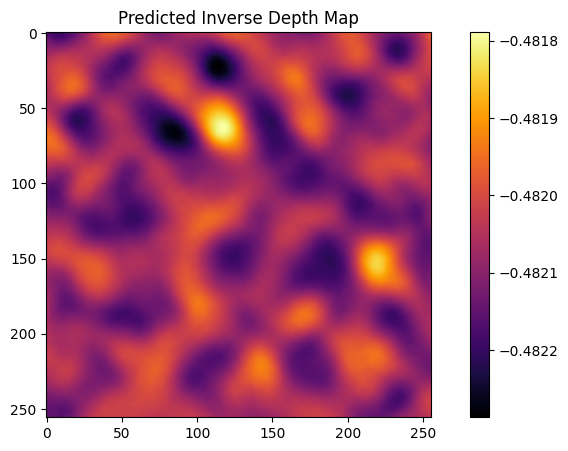

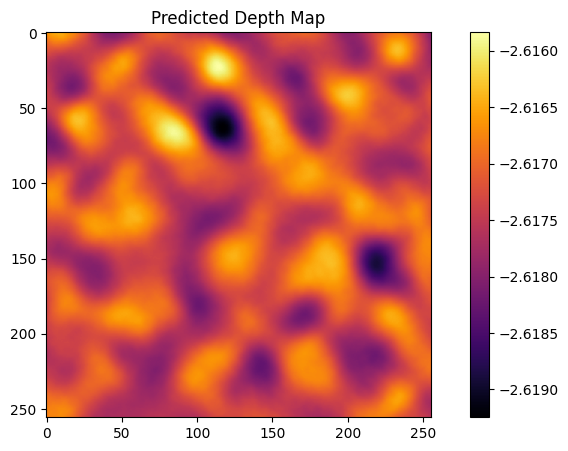

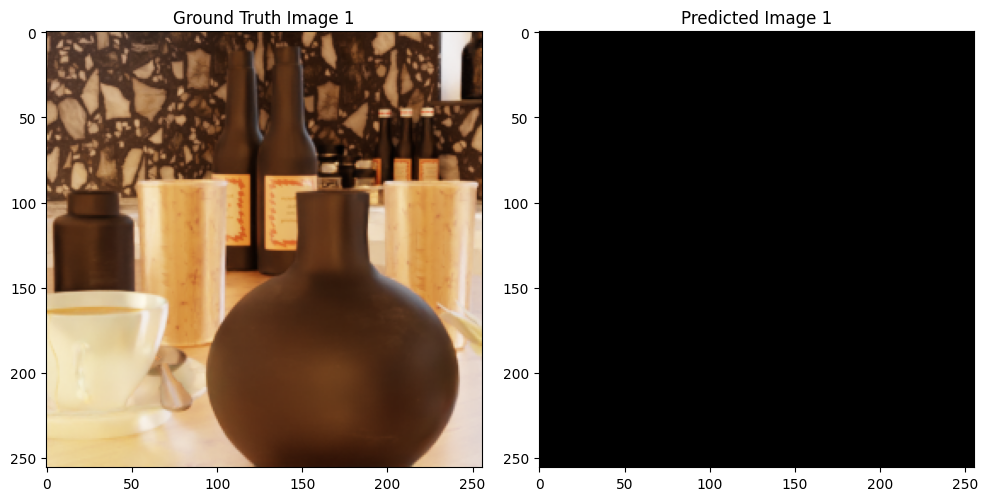

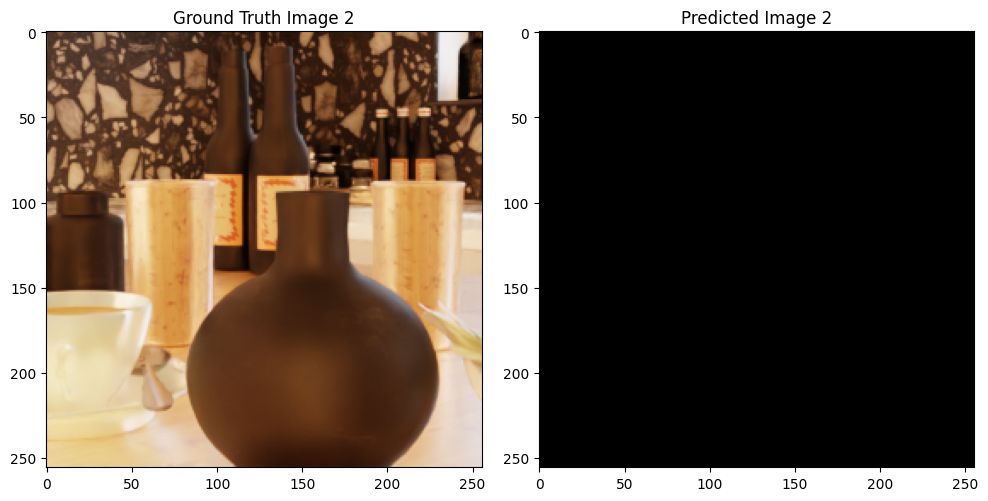

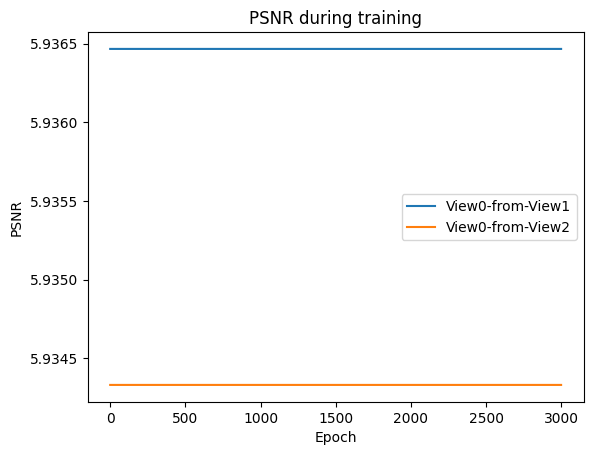

: 

In [61]:
psnr_v1fromv0, psnr_v2fromv0, pred_inverse_depth, pred_img_v1fromv0, pred_img_v2fromv0, pred_mask_1, pred_mask_2 = results
pred_inverse_depth = -pred_inverse_depth
# show the result of predicted inverse depth map
plt.figure(figsize=(10, 5))
plt.imshow(pred_inverse_depth.squeeze().cpu().detach().numpy(), cmap='inferno') # Call detach() before converting to NumPy array.
plt.title('Predicted Inverse Depth Map')
plt.colorbar()
plt.show()

# also the depth map computing the inverse of inverse depth map
pred_depth = 1 / (pred_inverse_depth + 0.1)
plt.figure(figsize=(10, 5))
plt.imshow(pred_depth.squeeze().cpu().detach().numpy(), cmap='inferno') # Call detach() before converting to NumPy array.
plt.title('Predicted Depth Map')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img1.permute(0,2,3,1).squeeze(0).cpu().detach().numpy()) #, cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Ground Truth Image 1')

plt.subplot(122)
plt.imshow(pred_img_v1fromv0.permute(0,2,3,1).squeeze(0).cpu().detach().numpy()) #, cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Predicted Image 1')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img2.permute(0,2,3,1).squeeze(0).cpu().detach().numpy() )# , cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Ground Truth Image 2')

plt.subplot(122)
plt.imshow(pred_img_v2fromv0.permute(0,2,3,1).squeeze(0).cpu().detach().numpy() ) #, cmap='gray') # Call detach() before converting to NumPy array.
plt.title('Predicted Image 2')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(psnr_v1fromv0, label='View0-from-View1')
plt.plot(psnr_v2fromv0, label='View0-from-View2')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR during training')
plt.legend()
plt.show()